# Global Parameters
#power of DL for channel est and signal detection of OFDM system

In [108]:
import os

import numpy as np
K = 64           # subcarriers
CP = K // 4      # cyclic prefix
P = 16           # pilots
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])

if P < K:
    pilotCarriers = allCarriers[::K // P]  # Pilots is every (K/P)th carrier.
    dataCarriers = np.delete(allCarriers, pilotCarriers)

else:  # K = P
    pilotCarriers = allCarriers
    dataCarriers = []

mu = 2
payloadBits_per_OFDM = K * mu
SNRdb = 25
n_hidden_1 = 500
n_hidden_2 = 250  # 1st layer num features
n_hidden_3 = 120  # 2nd layer num features
n_output = 16  # every 16 bit are predicted by a model


def Modulation(bits):
    bit_r = bits.reshape((int(len(bits) / mu), mu))
    # This is just for QAM modulation
    return (2 * bit_r[:, 0] - 1) + 1j * (2 * bit_r[:, 1] - 1)


def OFDM_symbol(Data, pilot_flag):
    symbol = np.zeros(K, dtype=complex)  # the overall K subcarriers
    #symbol = np.zeros(K)
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers
    symbol[dataCarriers] = Data  # allocate the pilot subcarriers
    return symbol


def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)


def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning


def channel(signal, channelResponse, SNRdb):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb / 10)
    noise = np.sqrt(sigma2 / 2) * (np.random.randn(*
                                                   convolved.shape) + 1j * np.random.randn(*convolved.shape))
    return convolved + noise


def removeCP(signal):
    return signal[CP:(CP + K)]


def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)


def ofdm_simulate(codeword, channelResponse, SNRdb):
    bits = np.random.binomial(n=1, p=0.5, size=(2*(K - P),))
    QAM = Modulation(bits)
    OFDM_data = np.zeros(K, dtype=complex)
    OFDM_data[pilotCarriers] = pilotValue
    OFDM_data[dataCarriers] = QAM
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time)
    OFDM_TX = OFDM_withCP
    OFDM_RX = channel(OFDM_TX, channelResponse, SNRdb)
    OFDM_RX_noCP = removeCP(OFDM_RX)
    OFDM_RX_noCP = DFT(OFDM_RX_noCP)

    # ----- target inputs ---
    symbol = np.zeros(K, dtype=complex)
    codeword_qam = Modulation(codeword)
    symbol[np.arange(K)] = codeword_qam
    OFDM_data_codeword = symbol
    OFDM_time_codeword = np.fft.ifft(OFDM_data_codeword)
    OFDM_withCP_cordword = addCP(OFDM_time_codeword)
    OFDM_RX_codeword = channel(OFDM_withCP_cordword, channelResponse, SNRdb)
    OFDM_RX_noCP_codeword = removeCP(OFDM_RX_codeword)
    OFDM_RX_noCP_codeword = DFT(OFDM_RX_noCP_codeword)
    return np.concatenate(
        (np.concatenate(
            (np.real(OFDM_RX_noCP), np.imag(OFDM_RX_noCP))), np.concatenate(
            (np.real(OFDM_RX_noCP_codeword), np.imag(OFDM_RX_noCP_codeword))))), abs(channelResponse)


Pilot_file_name = 'Pilot_' + str(P)
if os.path.isfile(Pilot_file_name):
    print('Load Training Pilots txt')
    # load file
    bits = np.loadtxt(Pilot_file_name, delimiter=',')
else:
    # write file
    bits = np.random.binomial(n=1, p=0.5, size=(K * mu, ))
    np.savetxt(Pilot_file_name, bits, delimiter=',')


pilotValue = Modulation(bits)

Load Training Pilots txt


# Generation

In [109]:
#from Global_parameters import *

channel_train = np.load('channel_train.npy')
train_size = channel_train.shape[0]
channel_test = np.load('channel_test.npy')
test_size = channel_test.shape[0]


def training_gen(bs, SNRdb = 20):
    while True:
        index = np.random.choice(np.arange(train_size), size=bs)
        H_total = channel_train[index]
        input_samples = []
        input_labels = []
        for H in H_total:
            bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM,))
            signal_output, para = ofdm_simulate(bits, H, SNRdb)
            input_labels.append(bits[0:16])       # Transmitted bits as DNN output
            input_samples.append(signal_output)   # Received bits as DNN input
        yield (np.asarray(input_samples), np.asarray(input_labels))


def validation_gen(bs, SNRdb = 20):
    while True:
        index = np.random.choice(np.arange(train_size), size=bs)
        H_total = channel_train[index]
        input_samples = []
        input_labels = []
        for H in H_total:
            bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM,))
            signal_output, para = ofdm_simulate(bits, H, SNRdb)
            input_labels.append(bits[0:16])
            input_samples.append(signal_output)
        yield (np.asarray(input_samples), np.asarray(input_labels))

# Define custom metric for bit error
def bit_err(y_true, y_pred):
    err = 1 - tf.reduce_mean(
        tf.cast(
            tf.reduce_mean(
                tf.cast(tf.equal(tf.sign(y_pred - 0.5), tf.sign(y_true - 0.5)), tf.float32),
                axis=1),
            tf.float32))
    return err

In [110]:
channel_train.shape
channel_train

array([[ 0.31994  +0.056713j  , -0.10715  -0.05253j   ,
        -0.1087   +0.15788j   , ...,  0.       +0.j        ,
         0.       +0.j        ,  0.       +0.j        ],
       [ 0.32603  -0.18088j   , -0.11205  +0.12034j   ,
         0.065691 -0.016139j  , ...,  0.       +0.j        ,
         0.       +0.j        ,  0.       +0.j        ],
       [ 0.22623  -0.39848j   , -0.0087778+0.18254j   ,
         0.20308  -0.29827j   , ...,  0.       +0.j        ,
         0.       +0.j        ,  0.       +0.j        ],
       ...,
       [-0.30239  +0.26467j   ,  0.47482  +0.29337j   ,
         0.84778  -0.37781j   , ...,  0.       +0.j        ,
         0.       +0.j        , -0.0088219+0.010404j  ],
       [ 0.25631  +0.41714j   ,  0.49614  -0.011494j  ,
         0.27815  +0.39557j   , ...,  0.       +0.j        ,
         0.       +0.j        , -0.013438 -0.00099531j],
       [ 0.54252  -0.118j     ,  0.09046  +0.13097j   ,
        -0.178    +0.56551j   , ...,  0.       +0.j        ,
 

In [111]:
channel_train.shape

(1000000, 16)

In [112]:
channel_test.shape

(390000, 16)

# Main

In [113]:
import numpy as np
from Global_parameters import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [114]:
# Build the model
input_bits = Input(shape=(payloadBits_per_OFDM * 2,))
temp = BatchNormalization()(input_bits)
temp = Dense(n_hidden_1, activation='relu')(temp)
temp = BatchNormalization()(temp)
temp = Dense(n_hidden_2, activation='relu')(temp)
temp = BatchNormalization()(temp)
temp = Dense(n_hidden_3, activation='relu')(temp)
temp = BatchNormalization()(temp)
out_put = Dense(n_output, activation='sigmoid')(temp)
model = Model(input_bits, out_put)

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=[bit_err])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
dense_16 (Dense)             (None, 500)               128500    
_________________________________________________________________
batch_normalization_18 (Batc (None, 500)               2000      
_________________________________________________________________
dense_17 (Dense)             (None, 250)               125250    
_________________________________________________________________
batch_normalization_19 (Batc (None, 250)               1000      
_________________________________________________________________
dense_18 (Dense)             (None, 120)               3012

In [115]:
# Define the checkpoint
checkpoint = ModelCheckpoint('./temp_trained_26.h5', monitor='val_bit_err',
                             verbose=0, save_best_only=True, mode='min', save_weights_only=True)

# Train the model
# Train the model and capture the history
history = model.fit(
    training_gen(1000, 25),
    steps_per_epoch=50,
    epochs=20,
    validation_data=validation_gen(100, 25),
    validation_steps=1,
    callbacks=[checkpoint],
    verbose=2
)

Epoch 1/20
50/50 - 14s - loss: 0.2227 - bit_err: 0.3563 - val_loss: 0.1845 - val_bit_err: 0.2100
Epoch 2/20
50/50 - 12s - loss: 0.1001 - bit_err: 0.1120 - val_loss: 0.1008 - val_bit_err: 0.0813
Epoch 3/20
50/50 - 12s - loss: 0.0541 - bit_err: 0.0558 - val_loss: 0.0600 - val_bit_err: 0.0562
Epoch 4/20
50/50 - 13s - loss: 0.0378 - bit_err: 0.0410 - val_loss: 0.0431 - val_bit_err: 0.0469
Epoch 5/20
50/50 - 13s - loss: 0.0287 - bit_err: 0.0314 - val_loss: 0.0316 - val_bit_err: 0.0331
Epoch 6/20
50/50 - 13s - loss: 0.0223 - bit_err: 0.0243 - val_loss: 0.0199 - val_bit_err: 0.0238
Epoch 7/20
50/50 - 12s - loss: 0.0180 - bit_err: 0.0198 - val_loss: 0.0157 - val_bit_err: 0.0163
Epoch 8/20
50/50 - 12s - loss: 0.0153 - bit_err: 0.0169 - val_loss: 0.0128 - val_bit_err: 0.0156
Epoch 9/20
50/50 - 12s - loss: 0.0132 - bit_err: 0.0146 - val_loss: 0.0118 - val_bit_err: 0.0125
Epoch 10/20
50/50 - 12s - loss: 0.0116 - bit_err: 0.0129 - val_loss: 0.0152 - val_bit_err: 0.0181
Epoch 11/20
50/50 - 12s - los

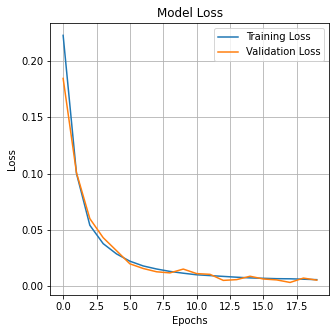

In [116]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(5, 5))

# Plot loss
#plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
#plt.tight_layout()
plt.show()

In [117]:
import h5py
# Open the HDF5 file in read/write mode
with h5py.File('./temp_trained_26.h5', 'r+') as f:
    # Convert `keras_version` to a byte string
    if isinstance(f.attrs['keras_version'], str):
        f.attrs['keras_version'] = f.attrs['keras_version'].encode('utf8')

In [118]:
#model.load_weights('./temp_trained_25.h5')
BER = []
for SNR in range(5, 30, 5):
    y = model.evaluate(
        validation_gen(10000, SNR),
        steps=1
    )
    BER.append(y[1])
    print(y)
print(BER)
BER_matlab = np.array(BER)
import scipy.io as sio
sio.savemat('BER.mat', {'BER':BER_matlab})

1/1 [==============================] - 0s 78ms/step - loss: 0.0804 - bit_err: 0.1025
[0.0804109051823616, 0.10254377126693726]
1/1 [==============================] - 0s 89ms/step - loss: 0.0280 - bit_err: 0.0372
[0.02804807759821415, 0.037231266498565674]
1/1 [==============================] - 0s 63ms/step - loss: 0.0117 - bit_err: 0.0154
[0.011654593981802464, 0.015412509441375732]
1/1 [==============================] - 0s 71ms/step - loss: 0.0068 - bit_err: 0.0085
[0.006772987544536591, 0.008506238460540771]
1/1 [==============================] - 0s 78ms/step - loss: 0.0050 - bit_err: 0.0057
[0.004984528291970491, 0.0057187676429748535]
[0.10254377126693726, 0.037231266498565674, 0.015412509441375732, 0.008506238460540771, 0.0057187676429748535]


No handles with labels found to put in legend.


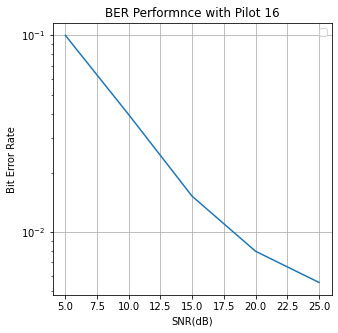

In [106]:
# Plot BER
plt.figure(figsize=(5, 5))
SNRdb =[5, 10, 15, 20, 25]
# Plot BER
#plt.subplot(1, 2, 2)
plt.semilogy(SNRdb, BER)
plt.title('BER Performnce with Pilot 16')
# Set y-ticks to display specific powers of ten
plt.xlabel('SNR(dB)')
plt.ylabel('Bit Error Rate')
plt.legend()
plt.grid()

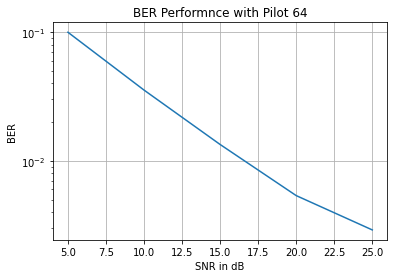

In [119]:
#We can run above program for diffrent length of Pilot P=8, 64 also and can check the MSE performance
# pilot = 64
import matplotlib.pyplot as plt
BER_64 = [0.099868774, 0.035512507, 0.013424993, 0.0053812265, 0.0029125214]
SNR = [5,10,15,20,25]
plt.semilogy(SNR, BER_64)
plt.xlabel('SNR in dB')
plt.ylabel('BER')
plt.title('BER Performnce with Pilot 64')
plt.grid()

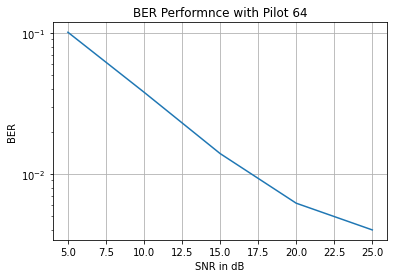

In [120]:
pilot = 8
BER_8 = [0.10129374, 0.03803748, 0.013956249, 0.0062000155, 0.0040062666]
SNR = [5,10,15,20,25]
plt.semilogy(SNR, BER_8)
plt.xlabel('SNR in dB')
plt.ylabel('BER')
plt.title('BER Performnce with Pilot 64')
plt.grid()